In [18]:
import gymnasium as gym
import ale_py
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation

In [32]:
env = gym.make("ALE/Breakout-v5", frameskip=1)

In [33]:
env = AtariPreprocessing(

    env,

    noop_max=10, frame_skip=4, terminal_on_life_loss=True,

    screen_size=84, grayscale_obs=True, grayscale_newaxis=False

)
env = FrameStackObservation(env, stack_size=4)

In [20]:
obs, _ = env.reset()

obs.shape

(4, 84, 84)

0.0045000000000000005
0
t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 13
t= 14
t= 15
t= 16
t= 17
t= 18
t= 19
t= 20
t= 21
t= 22
t= 23
t= 24
t= 25
t= 26
t= 27
t= 28
t= 29
t= 30
t= 31
t= 32
t= 33
t= 34
t= 35
t= 36
t= 37
t= 38
t= 39
t= 40
t= 41
t= 42
t= 43
t= 44
t= 45
t= 46
t= 47
t= 48
t= 49
t= 50
t= 51
t= 52
t= 53
t= 54
t= 55
t= 56
t= 57
t= 58
t= 59
t= 60
t= 61
t= 62
t= 63
t= 64
t= 65
t= 66
t= 67
t= 68
t= 69
t= 70
t= 71
t= 72
t= 73
t= 74
t= 75
t= 76
t= 77
t= 78
t= 79
t= 80
t= 81
t= 82
t= 83
t= 84
t= 85
t= 86
t= 87
t= 88
t= 89
t= 90
t= 91
t= 92
t= 93
t= 94
t= 95
t= 96
t= 97
t= 98
t= 99
t= 100
t= 101
t= 102
t= 103
t= 104
t= 105
t= 106
t= 107
t= 108
t= 109
t= 110
t= 111
t= 112
t= 113
t= 114
t= 115
t= 116
t= 117
t= 118
t= 119
t= 120
t= 121
t= 122
t= 123
t= 124
t= 125
t= 126
t= 127
t= 128
t= 129
t= 130
t= 131
t= 132
t= 133
t= 134
t= 135
t= 136
t= 137
t= 138
t= 139
t= 140
t= 141
t= 142
t= 143
t= 144
t= 145
Episode 1: Reward = 0.0, Epsilon = 0.3430000000000056
1
t= 0
t= 

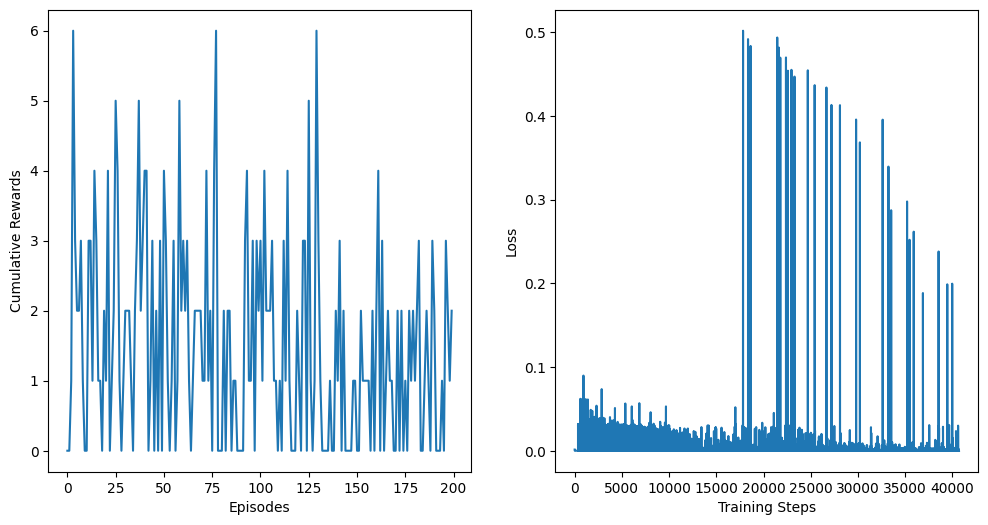

In [48]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
# CNN-Based DQN Model
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        # fully connected 
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
BUFFER_SIZE = 100000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 200
TARGET_UPDATE = 1000

# Training Function
def train_dqn(env, model, target_model, replay_buffer, optimizer, n_episodes=200):
    epsilon = EPSILON_START
    # we use epsilon decay 
    epsilon_decay = (EPSILON_START - EPSILON_END) / EPSILON_DECAY
    print(epsilon_decay)
    total_rewards = []
    # residual
    losses = []

    for episode in range(n_episodes):
        print(episode)
        state, _ = env.reset()
        epsilon = EPSILON_START
        total_reward = 0

        for t in range(1000):
            print(f"t= {t}")
            # Select action
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    # here our q_values are computed via the CNN-model (torch) not via the update formula in Q-learning
                    q_values = model(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                    action = torch.argmax(q_values).item()

            # Decay epsilon
            epsilon = max(EPSILON_END, epsilon - epsilon_decay)

            # Step in environment
            next_state, reward, done, _, _ = env.step(action)

            # we store the transition in the replay buffer
            replay_buffer.push((state, action, reward, next_state, done))
            # we update our values the preprocessing is done automatically by the env
            state = next_state
            total_reward += reward

            # Train model
            if len(replay_buffer) >= BATCH_SIZE:
                # sample from the buffer 
                batch = replay_buffer.sample(BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)

                # and convert data types
                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.int64)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.bool)
                
                # computing the y_j 
                q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    # TODO: rewrite in if case
                    target_q_values = rewards + GAMMA * target_model(next_states).max(1)[0] * (~dones)

                # compute the loss (residual)
                loss = nn.MSELoss()(q_values, target_q_values)
                #steps for gradient descent
                optimizer.zero_grad()
                loss.backward()
                # update the parameters \theta
                optimizer.step()

                losses.append(loss.item())

            if done:
                break

        total_rewards.append(total_reward)
        # every TARGET_UPDATE (C) steps reset the target Q values to training Q values
        if episode % TARGET_UPDATE == 0:
            target_model.load_state_dict(model.state_dict())

        print(f"Episode {episode + 1}: Reward = {total_reward}, Epsilon = {epsilon}")

    return total_rewards, losses

# Main
if __name__ == "__main__":
    env = gym.make("ALE/Breakout-v5", frameskip=1)
    env = AtariPreprocessing(env, frame_skip=4, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)
    n_actions = env.action_space.n

    model = DQN(n_actions)
    target_model = DQN(n_actions)
    target_model.load_state_dict(model.state_dict())

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    replay_buffer = ReplayBuffer(BUFFER_SIZE)

    rewards, losses = train_dqn(env, model, target_model, replay_buffer, optimizer)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Rewards")

    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")

    plt.show()
